In [1]:
import pandas as pd
import numpy as np
import os

# 设置随机种子以确保结果可复现
seed = 42
np.random.seed(seed)

# 文件路径和名称
input_dir = "D:\\Bioinformatics\\personal research\\WCM output\\zipA+aa"
file_names = [
    'data1_zipa.csv', 'data2_zipa.csv', 'data3_zipa.csv', 'data4_zipa.csv',
    'data5_zipa.csv', 'data6_zipa.csv', 'data7_zipa.csv', 'data8_zipa.csv',
    'data9_zipa.csv', 'data10_zipa.csv', 'data11_zipa.csv', 'data12_zipa.csv',
    'data13_zipa.csv', 'data14_zipa.csv', 'data15_zipa.csv', 'data16_zipa.csv',
    'data17_zipa.csv', 'data18_zipa.csv', 'data19_zipa.csv'
]

# 打乱文件列表
np.random.shuffle(file_names)

# 划分文件
train_files = file_names[:15]
val_files = file_names[15:17]
test_files = file_names[17:]

# 函数：读取文件并合并成一个DataFrame
def read_and_concatenate(files):
    dfs = [pd.read_csv(os.path.join(input_dir, file)) for file in files]
    return pd.concat(dfs, ignore_index=True)

# 读取数据
train_data = read_and_concatenate(train_files)
val_data = read_and_concatenate(val_files)
test_data = read_and_concatenate(test_files)

# 保存数据集到文件
output_dir = 'D://Bioinformatics//personal research//WCM output//zipA'
os.makedirs(output_dir, exist_ok=True)

train_data.to_csv(os.path.join(output_dir, 'train_data.csv'), index=False)
val_data.to_csv(os.path.join(output_dir, 'val_data.csv'), index=False)
test_data.to_csv(os.path.join(output_dir, 'test_data.csv'), index=False)

print('数据集分割并保存完成！')

数据集分割并保存完成！


In [2]:
train_data = train_data.sort_values(by=['gene_ko','generation'])
val_data = val_data.sort_values(by=['gene_ko','generation'])
test_data = test_data.sort_values(by=['gene_ko','generation'])

train_df = train_data.iloc[:, 2:].copy()
val_df = val_data.iloc[:, 2:].copy()
test_df = test_data.iloc[:, 2:].copy()

print("Training set:")
print(train_df.head(), "\n")

print("Validation set:")
print(val_df.head(), "\n")

print("Test set:")
print(test_df.head(), "\n")

Training set:
         time  generation     cellMass  L-ASPARTATE[c]  G7258-MONOMER[i]  \
110504    0.0           0  1321.397615         1832428               239   
110505   60.0           0  1336.333793         1860843               243   
110506  120.0           0  1354.939001         1922170               247   
110507  180.0           0  1373.169949         1971182               250   
110508  240.0           0  1391.997141         1997306               252   

        label  
110504      0  
110505      0  
110506      0  
110507      0  
110508      0   

Validation set:
        time  generation     cellMass  L-ASPARTATE[c]  G7258-MONOMER[i]  label
31294    0.0           0  1318.774994         1828791               265      0
31295   60.0           0  1332.276199         1830963               265      0
31296  120.0           0  1349.942672         1873252               265      0
31297  180.0           0  1368.194975         1900267               265      0
31298  240.0        

In [3]:
# Select the feature columns to be standardized
features = ['cellMass', 'L-ASPARTATE[c]','G7258-MONOMER[i]']

# Calculate the mean and standard deviation of the training set
train_mean = train_df[features].mean()
train_std = train_df[features].std()

print("Training set mean:\n", train_mean)
print("Training set std:\n", train_std)

Training set mean:
 cellMass            1.739083e+03
L-ASPARTATE[c]      2.199624e+06
G7258-MONOMER[i]    3.066150e+02
dtype: float64
Training set std:
 cellMass              9290.631277
L-ASPARTATE[c]      659664.159180
G7258-MONOMER[i]        98.731495
dtype: float64


In [4]:
train_df[features] = (train_df[features] - train_mean) / train_std
val_df[features] = (val_df[features] - train_mean) / train_std
test_df[features] = (test_df[features] - train_mean) / train_std

normTrnMean = train_df[features].mean()
print(normTrnMean)
normValMean = val_df[features].mean()
print(normValMean)
normTstMean = test_df[features].mean()
print(normTstMean)

cellMass            7.532192e-18
L-ASPARTATE[c]     -1.299546e-16
G7258-MONOMER[i]    2.182719e-16
dtype: float64
cellMass           -0.020374
L-ASPARTATE[c]      0.073953
G7258-MONOMER[i]    0.123163
dtype: float64
cellMass           -0.022782
L-ASPARTATE[c]      0.030297
G7258-MONOMER[i]    0.030809
dtype: float64


In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, label_columns=None):
        # Store raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label Column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, model=None, plot_col='cellMass', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
        plt.xlabel('Time /s')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=32
        )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            # and cache for next time
            self._example = result
        return result

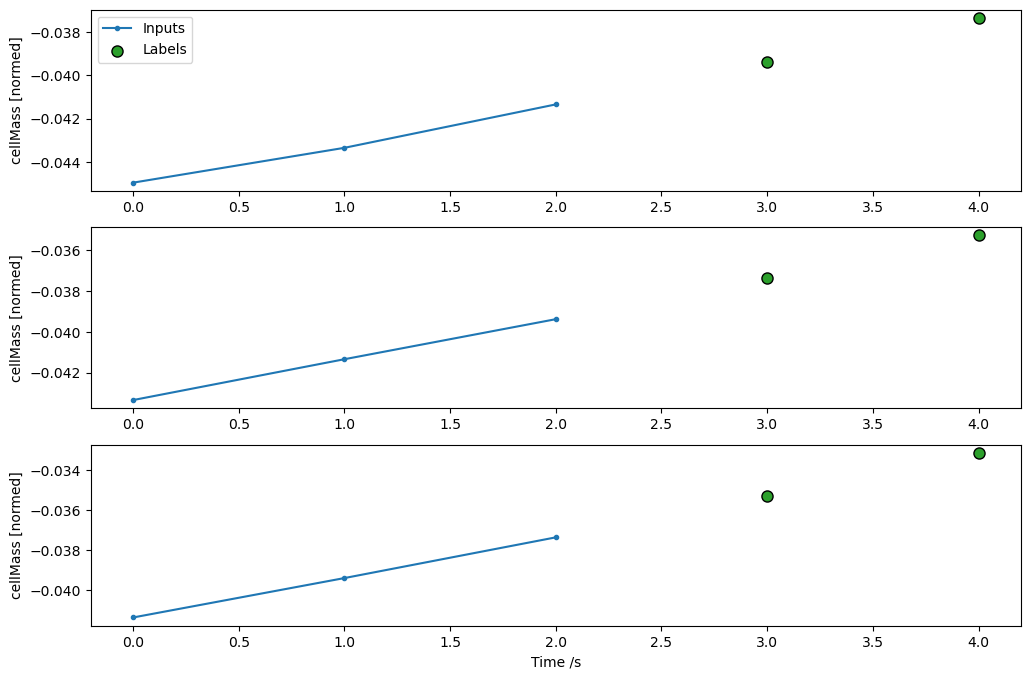

In [7]:
conv_window = WindowGenerator(
    input_width=3,
    label_width=2,
    shift=2,
    train_df=train_df[features],
    val_df=val_df[features],
    test_df=test_df[features],
    label_columns=['cellMass']
)
conv_window.plot()

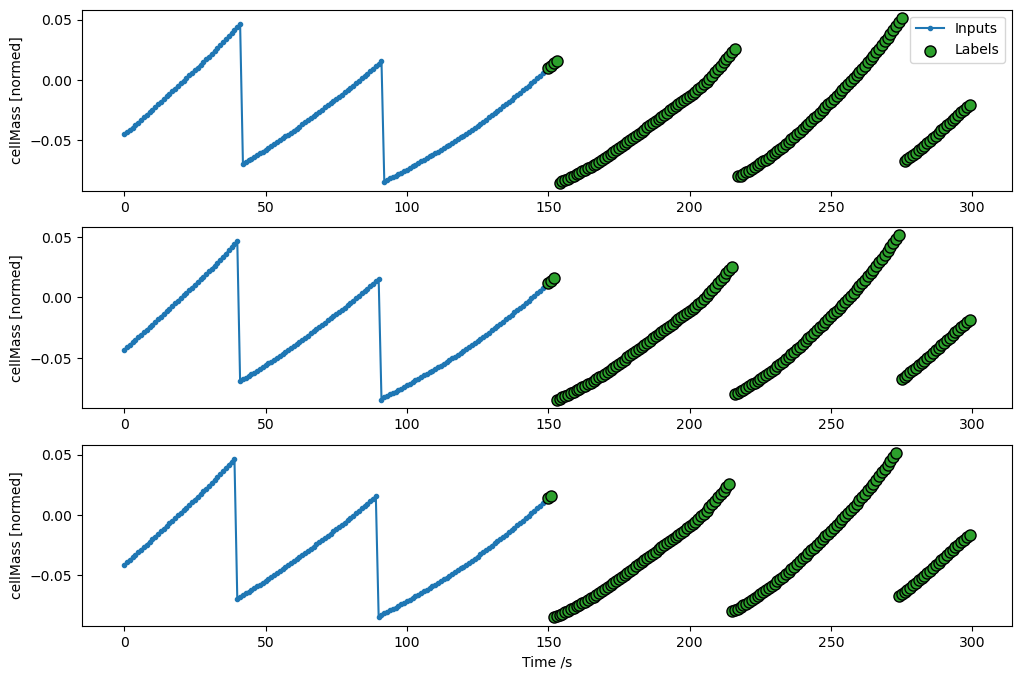

In [9]:
MAX_EPOCHS = 10
OUT_STEPS = 150
multi_window = WindowGenerator(input_width=150,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['cellMass'],
                               train_df=train_df[features],
                               val_df=val_df[features],
                               test_df=test_df[features])

multi_window.plot()
multi_window

multi_lstm_model = tf.keras.Sequential([
    #shape [batch, time, features] => [batch, lstm_units]
    #adding more lstm units just overfits more quickly
    tf.keras.layers.LSTM(32, return_sequences=False),
    #shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1),
                         # kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [10]:
import pickle
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import datetime
import time
import IPython


1943/1943 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - loss: 9.2293e-04 - mean_absolute_error: 0.0238


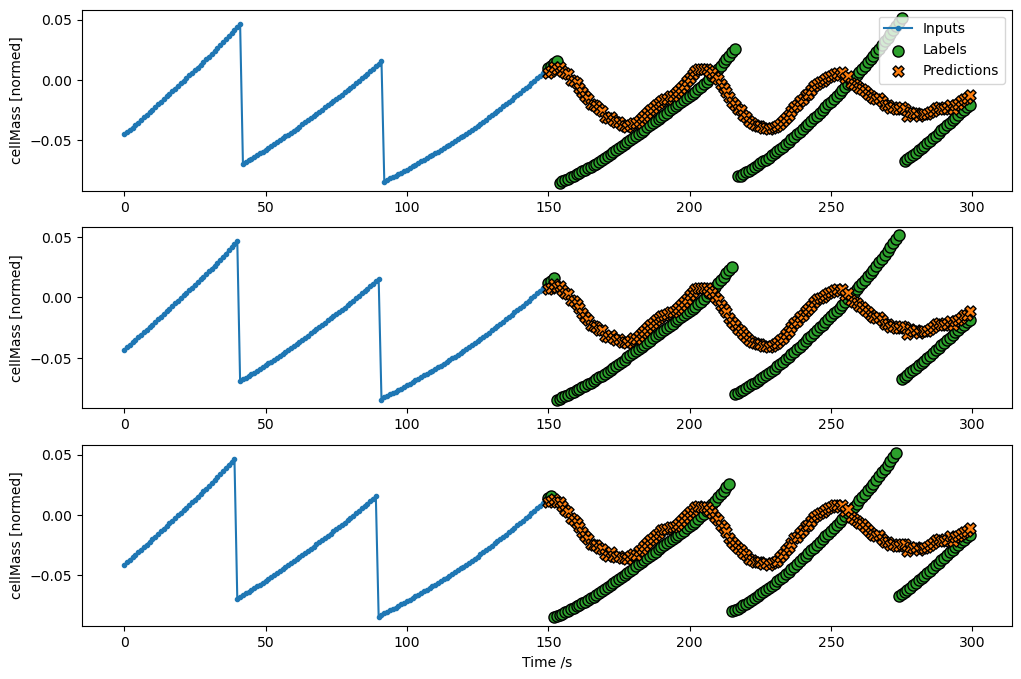

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

multi_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = multi_lstm_model.fit(multi_window.train, epochs=12,
                    validation_data=multi_window.val,
                    callbacks=[early_stopping])

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

<Figure size 640x480 with 0 Axes>

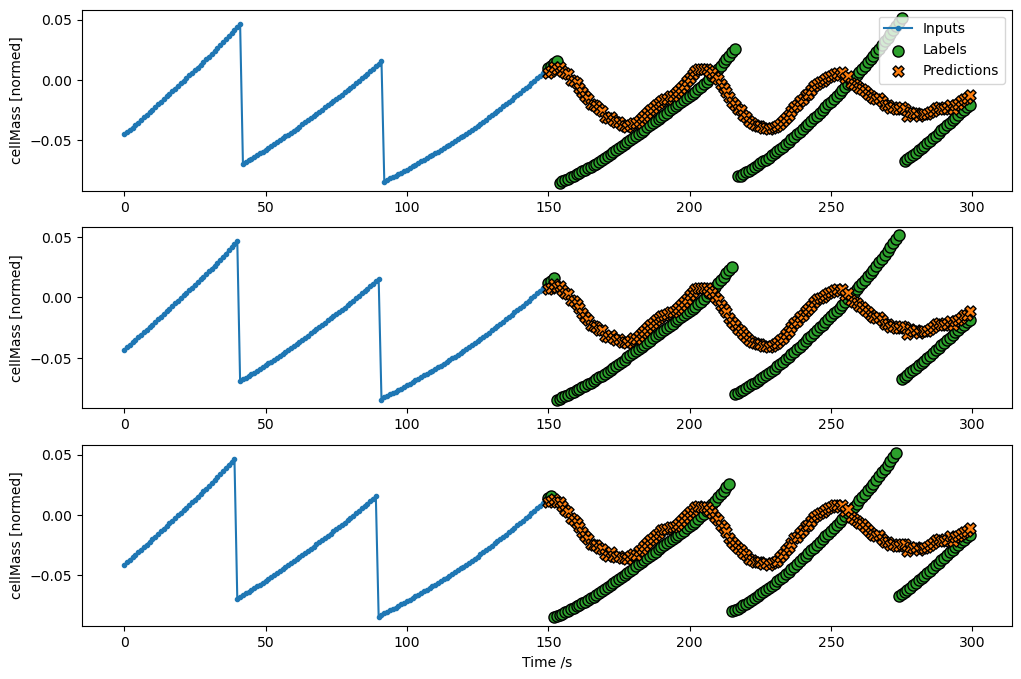

In [12]:
plt.figure()
multi_window.plot(multi_lstm_model)
output_path = "D:\\Bioinformatics\\personal research\\WCM output\\zipA+aa\\ko_aa+gene_cm_180.png"# 替换为你的路径
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show() 